# scikit-FIBERS: Demonstration Notebook
This notebook is set up as a demonstration for running scikit-FIBERS.

## Installation:

In [1]:
#Add Installation code

## Imports:

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
#from paretoset import paretoset
from sklearn.metrics import classification_report
from src.skfibers.fibers import FIBERS
from src.skfibers.experiments.datagen import create_data_simulation_bin
from src.skfibers.experiments.datagen_evolvable_threshold import create_data_simulation_bin_evolve

current_working_directory = os.getcwd()
print(current_working_directory)

c:\Users\ryanu\OneDrive\Documents\GitHub\scikit-FIBERS


## Survial Data Simulation

In [3]:
data = create_data_simulation_bin_evolve(number_of_instances=10000, number_of_features=100, number_of_features_in_bin=10,
                                  no_fail_proportion=0.5, mm_frequency_range=(0.4, 0.5), noise_frequency=0.0,
                                  class0_time_to_event_range=(1.5, 0.2), class1_time_to_event_range=(1, 0.2),
                                  censoring_frequency=0.5, random_seed=42, negative=False, threshold=0)
data.to_csv('sampledata.csv', index=False)
data = pd.read_csv('sampledata.csv')
true_risk_group = data[['TrueRiskGroup']]
data = data.drop('TrueRiskGroup', axis=1)

## Running FIBERS (Training)

In [4]:
fibers = FIBERS(outcome_label="Duration", outcome_type="survival", iterations=50, pop_size = 50, crossover_prob=0.5, mutation_prob=0.1, 
                new_gen=1.0, elitism=0.1, min_bin_size=1, fitness_metric="log_rank", log_rank_weighting=None,
                censor_label="Censoring", group_strata_min=0.2, group_thresh=None, min_thresh=0, max_thresh=3, int_thresh=True, thresh_evolve_prob=0.5,
                manual_bin_init=None, covariates=None, report=None, random_seed=None, verbose=False)

fibers = fibers.fit(data)

Beginning FIBERS Fit:


100%|██████████| 50/50 [01:23<00:00,  1.68s/it]

Random Seed Check - End: 0.12170177694022866
FIBERS Run Complete!
Elapsed Time (sec):  89.99092221260071 seconds


## Top-Bin Examination

### 

In [5]:
bin_index = 0 # lowest index is the bin with the highest fitness (only reports the bin ranked at the top, despite possible fitness ties for top)
# Get bin reportting variables 
low_outcome, high_outcome, low_censor, high_censor, bin_report_df = fibers.get_bin_groups(data, bin_index)
print(bin_report_df)

                                                                         0
Features in Bin:           [P_10, P_2, P_3, P_4, P_5, P_6, P_8, P_9, R_89]
Threshold:                                                               1
Fitness:                                                        5497.67814
Metric Score:                                                   5497.67814
p-value:                                                               0.0
Bin Size:                                                                9
Group Ratio:                                                           0.5
Count At/Below Threshold:                                             5000
Count Above Threshold:                                                5000
Birth Iteration:                                                        48


### Kaplan Meier Survival Plot (For Top Bin)

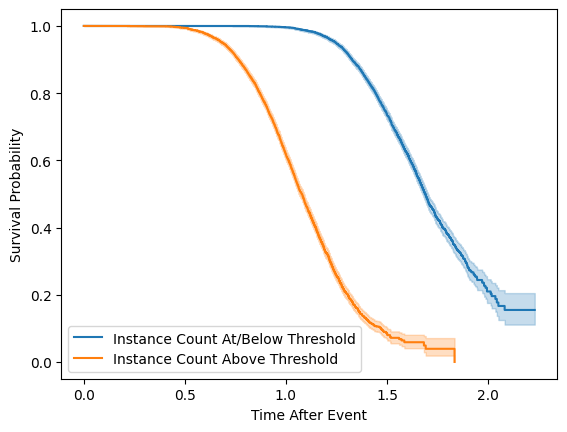

In [6]:
kmf1 = KaplanMeierFitter()

# fit the model for 1st cohort
kmf1.fit(low_outcome, low_censor, label='Instance Count At/Below Threshold')
a1 = kmf1.plot_survival_function()
a1.set_ylabel('Survival Probability')

# fit the model for 2nd cohort
kmf1.fit(high_outcome, high_censor, label='Instance Count Above Threshold')
kmf1.plot_survival_function(ax=a1)
a1.set_xlabel('Time After Event')

plt.show()

### Check and View Top Bin Ties

### 

In [7]:
top_bin_list = fibers.get_top_bins()
count = len(top_bin_list)
if count > 1:
    print(str(len(top_bin_list))+" bins were tied for best fitness")
    for bin in top_bin_list:
        #print("Features in Bin: "+str(bin.feature_list))
        report = bin.bin_short_report()
        print(report)
else:
    print("Only one top performing bin found")


20 bins were tied for best fitness
                                                                0
Features in Bin:  [P_10, P_2, P_3, P_4, P_5, P_6, P_8, P_9, R_89]
Threshold:                                                      1
Fitness:                                               5497.67814
Bin Size:                                                       9
Group Ratio:                                                  0.5
Birth Iteration:                                               48
                                                     0
Features in Bin:  [P_10, P_2, P_3, P_4, P_5, P_6, P_7]
Threshold:                                           0
Fitness:                                    5497.67814
Bin Size:                                            7
Group Ratio:                                       0.5
Birth Iteration:                                    41
                                                              0
Features in Bin:  [P_2, P_3, P_4, P_5, P_6, P_7, P_8, 

## History of Bin Evolution
### Plot: Fitness of top bin each training iteration

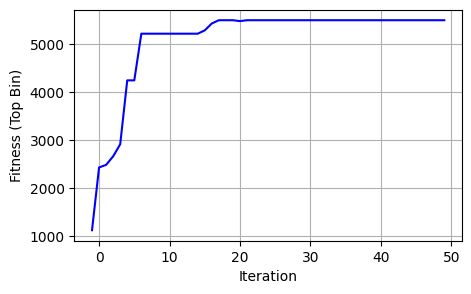

In [8]:
# Extract columns for plotting
time = fibers.top_perform_df['Iteration']
df = fibers.top_perform_df[['Fitness']]

# Plot the data
plt.figure(figsize=(5, 3))
colors = ['blue']  # Manually set colors
for i, column in enumerate(df.columns):
    plt.plot(time, df[column], label=column, color=colors[i])

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Fitness (Top Bin)')
#plt.title('Top Bin Fitness Across Training Iterations')

# Show the plot
plt.grid(True)
plt.show()

### Plot: Normalized Top-Bin Stats Across Training Iterations

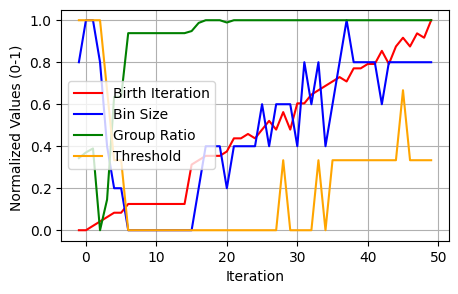

In [9]:
# Extract columns for plotting
time = fibers.top_perform_df['Iteration']
df = fibers.top_perform_df[['Birth Iteration','Bin Size','Group Ratio','Threshold']]
df = (df - df.min()) / (df.max() - df.min())
# Plot the data
plt.figure(figsize=(5, 3))
colors = ['red', 'blue', 'green', 'orange']   # Manually set colors
for i, column in enumerate(df.columns):
    plt.plot(time, df[column], label=column, color=colors[i])

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Normalized Values (0-1) ')
#plt.title('Normalized Top-Bin Stats Across Training Iterations')
plt.legend()  # Show legend

# Show the plot
plt.grid(True)
plt.show()

### View: The dataframe containing all top-bin statistics/characteristics across training iterations

In [10]:
print(fibers.top_perform_df)

    Iteration                                            Top Bin  Threshold  \
0          -1  [P_9, R_45, R_10, R_85, P_8, R_30, P_2, R_76, ...          3   
1           0  [P_2, P_4, P_5, P_8, P_9, R_12, R_29, R_68, R_...          3   
2           1  [P_10, P_2, P_4, P_5, P_8, P_9, R_10, R_29, R_...          3   
3           2  [P_10, P_2, P_4, P_5, P_8, P_9, R_11, R_12, R_69]          3   
4           3             [P_10, P_4, P_5, P_8, P_9, R_11, R_69]          2   
5           4                   [P_10, P_4, P_5, P_8, P_9, R_11]          1   
6           5                   [P_10, P_4, P_5, P_8, P_9, R_11]          1   
7           6                         [P_10, P_4, P_5, P_8, P_9]          0   
8           7                         [P_10, P_4, P_5, P_8, P_9]          0   
9           8                         [P_10, P_4, P_5, P_8, P_9]          0   
10          9                         [P_10, P_4, P_5, P_8, P_9]          0   
11         10                         [P_10, P_4, P_

## Transforming Bins Into New Features (Feature Learning)

In [11]:
tdf = fibers.transform(data)
print(tdf)

      Bin_0  Bin_1  Bin_2  Bin_3  Bin_4  Bin_5  Bin_6  Bin_7  Bin_8  Bin_9  \
0         0      0      0      0      1      1      0      1      1      1   
1         3      2      3      3      4      3      4      2      3      3   
2         1      0      1      0      0      1      1      0      0      0   
3         2      3      3      3      2      4      3      3      3      3   
4         1      0      0      0      0      1      1      0      0      0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
9995      0      0      0      0      0      0      1      0      1      0   
9996      0      0      0      0      0      0      0      1      1      1   
9997      1      0      1      0      0      0      0      1      0      1   
9998      4      4      4      4      4      4      4      4      5      4   
9999      0      0      1      0      0      1      1      0      0      0   

      ...  Bin_42  Bin_43  Bin_44  Bin_45  Bin_46  Bin_47  Bin_

## Prediction (of Strata)
### Predict Strata (Low vs. High) Using Top Bin

In [12]:
predictions = fibers.predict(data,bin_number=0)
print(classification_report(predictions, true_risk_group))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5000
           1       1.00      1.00      1.00      5000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



### Predict Strata (Low vs. High) Using Whole Bin Population (Weighted Voting Scheme)

In [13]:
predictions = fibers.predict(data)
print(classification_report(predictions, true_risk_group))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      3992
           1       1.00      0.83      0.91      6008

    accuracy                           0.90     10000
   macro avg       0.90      0.92      0.90     10000
weighted avg       0.92      0.90      0.90     10000



## Pareto Front Visualization

In [14]:
pop_df = fibers.set.get_pop()
print(isinstance(pop_df, pd.DataFrame))
print(pop_df)
pop_df.to_csv('FIBERS_pop.csv', index=False)

TypeError: Index(...) must be called with a collection of some kind, False was passed

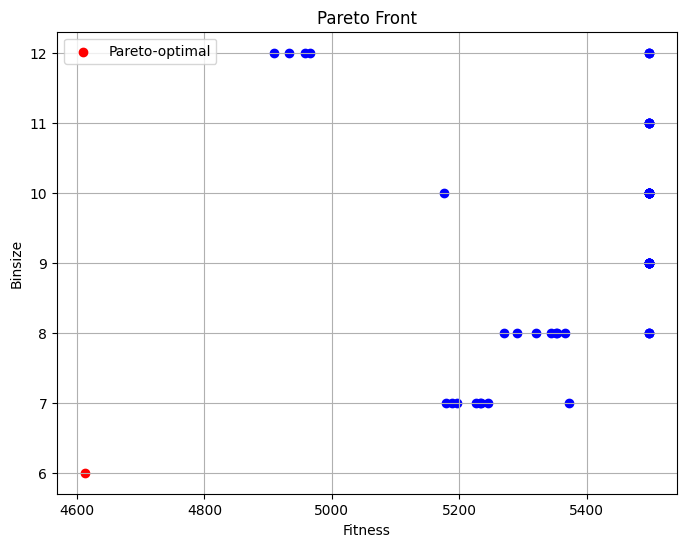

In [ ]:

bin_pop = fibers.set.bin_pop
# Initialize lists to store Pareto-optimal solutions
pareto_fitness = []
pareto_binsize = []

# Plot the data
plt.figure(figsize=(8, 6))
for bin in bin_pop:
    fitness = bin.fitness
    binsize = bin.bin_size
    dominated = False
    
    for other_bin in bin_pop:
        if (other_bin.fitness < fitness and other_bin.bin_size < binsize) \
            or (other_bin.fitness <= fitness and other_bin.bin_size < binsize) \
            or (other_bin.fitness < fitness and other_bin.bin_size <= binsize):
            dominated = True
            break
            
    if not dominated:
        pareto_fitness.append(fitness)
        pareto_binsize.append(binsize)
        plt.scatter(fitness, binsize, color='red', label='Pareto-optimal')
    else:
        plt.scatter(fitness, binsize, color='blue')

# Add labels and title
plt.xlabel('Fitness')
plt.ylabel('Binsize')
plt.title('Pareto Front')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [ ]:
pop_df = fibers.set.report_pop()

print(pop_df)
max_bin_size = pop_df['Bin Size:'].max()
print(max_bin_size)
object_list = pop_df[['Fitness','Bin Size']]

bin_pop = fibers.set.bin_pop
# Initialize lists to store Pareto-optimal solutions
pareto_fitness = []
pareto_binsize = []

# Sort objects based on fitness (to be maximized) and binsize (to be minimized)
sorted_objects = sorted(object_list, key=lambda x: (x['fitness'], -x['binsize']))

# Initialize lists to store Pareto-optimal solutions
pareto_fitness = []
pareto_binsize = []

# Plot the data
plt.figure(figsize=(8, 6))
for i, obj in enumerate(sorted_objects):
    fitness = obj['fitness']
    binsize = obj['binsize']
    dominated = False
    
    for other_obj in sorted_objects[i + 1:]:
        if other_obj['fitness'] > fitness and other_obj['binsize'] < binsize:
            dominated = True
            break
            
    if not dominated:
        pareto_fitness.append(fitness)
        pareto_binsize.append(binsize)
        plt.scatter(fitness, binsize, color='red', label='Pareto-optimal')
    else:
        break

# Draw a line representing the non-dominated front
plt.plot(pareto_fitness, pareto_binsize, color='green', linestyle='-', linewidth=2, label='Non-dominated front')

# Add labels and title
plt.xlabel('Fitness (Maximize)')
plt.ylabel('Binsize (Minimize)')
plt.title('Pareto Front')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

                                         feature_list  group_threshold  \
0   [P_1, P_10, P_2, P_3, P_4, P_5, P_6, P_7, P_8,...                2   
1           [P_1, P_10, P_2, P_3, P_4, P_5, P_7, P_8]                1   
2   [P_1, P_10, P_2, P_3, P_4, P_5, P_6, P_7, P_8,...                0   
3      [P_1, P_10, P_2, P_3, P_4, P_5, P_6, P_7, P_8]                1   
4   [P_1, P_10, P_2, P_3, P_4, P_5, P_6, P_7, P_9,...                1   
5   [P_1, P_10, P_3, P_4, P_5, P_6, P_7, P_8, P_9,...                2   
6     [P_1, P_10, P_2, P_4, P_5, P_6, P_8, P_9, R_80]                1   
7   [P_1, P_10, P_2, P_3, P_4, P_6, P_7, P_8, P_9,...                2   
8     [P_1, P_10, P_2, P_3, P_4, P_5, P_6, P_7, R_82]                1   
9   [P_1, P_10, P_2, P_4, P_5, P_6, P_7, P_8, P_9,...                1   
10  [P_1, P_10, P_2, P_4, P_5, P_6, P_7, P_8, P_9,...                2   
11    [P_1, P_10, P_2, P_4, P_6, P_7, P_8, P_9, R_43]                1   
12    [P_1, P_10, P_2, P_4, P_5, P_6, 

TypeError: 'NoneType' object is not subscriptable